# SciCite EDA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import torch
import re
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder


sns.set_theme()


# Torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
train_df = pd.read_json(path_or_buf=r'.\scicite\train.jsonl', lines=True)
test_df = pd.read_json(path_or_buf=r'.\scicite\test.jsonl', lines=True)
val_df = pd.read_json(path_or_buf=r'.\scicite\dev.jsonl', lines=True)
train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


## Label Confidence

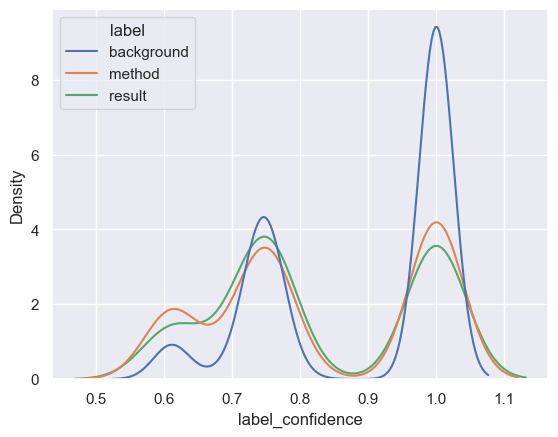

In [3]:
sns.kdeplot(data=train_df, x="label_confidence", hue="label", common_norm=False)
plt.show()

In [6]:
train_df["label_confidence"].mean()

0.876606045299006

## citeStart

<Axes: xlabel='citeStart', ylabel='Density'>

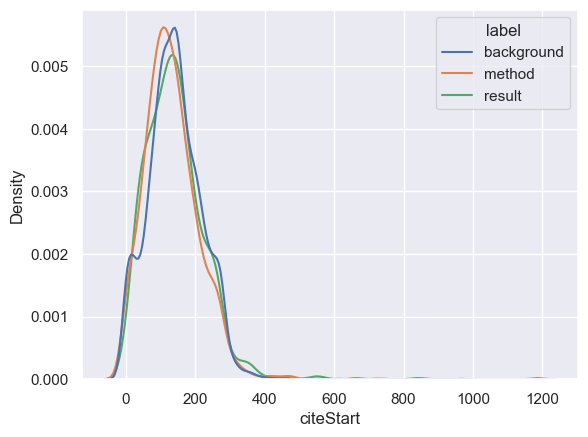

In [40]:
sns.kdeplot(data=train_df, x="citeStart", hue="label", common_norm=False)
plt.show()

## citeEnd

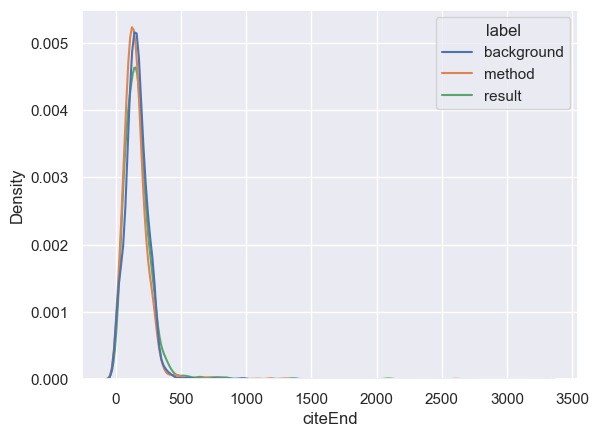

In [41]:
sns.kdeplot(data=train_df, x="citeEnd", hue="label", common_norm=False)
plt.show()

## Excerpt Index

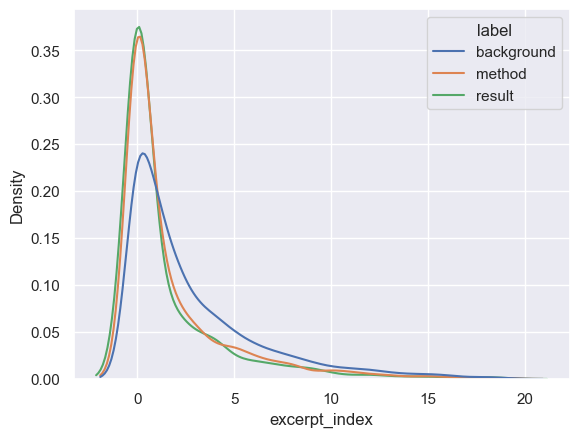

In [42]:
sns.kdeplot(data=train_df, x="excerpt_index", hue="label", common_norm=False)
plt.show()

## IsKeyCitation

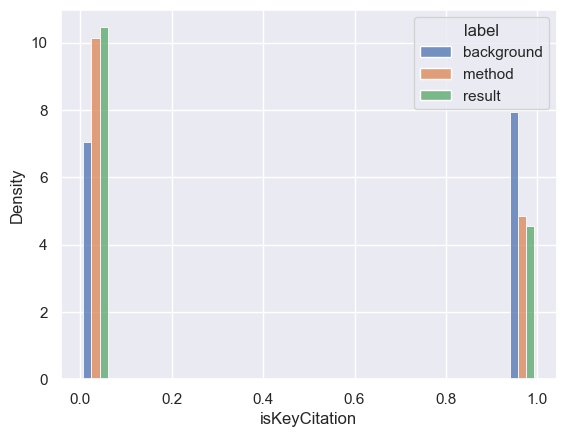

In [47]:
sns.histplot(data=train_df, x="isKeyCitation", hue="label", multiple="dodge", shrink=.8, stat="density", common_norm=False)
plt.show()

## Source

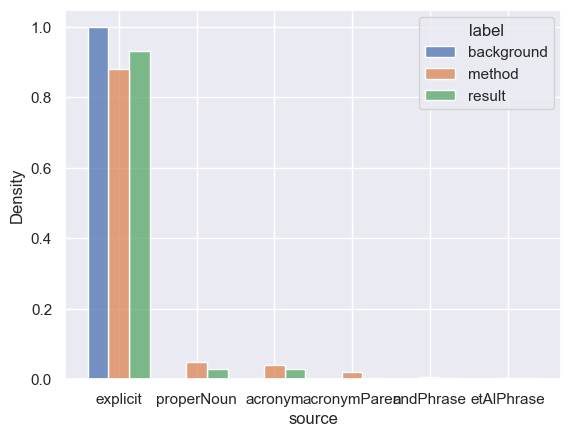

In [48]:
sns.histplot(data=train_df, x="source", hue="label", multiple="dodge", shrink=.8, stat="density", common_norm=False)
plt.show()

* Proper noun not present in background.
* Essentially all are explicit in background.

## Section Name

In [49]:
def parse_section_name(raw_section_name):
    if raw_section_name is None or not raw_section_name.strip():
        return ""
    for i, c in enumerate(raw_section_name):
        if c.isalpha():
            break
    section_name = raw_section_name[i:]
    section_name = section_name.lower()
    return section_name.strip()


train_df["sectionName"] = train_df["sectionName"].apply(parse_section_name)

In [77]:
train_df["sectionName"].value_counts()[:25]

sectionName
discussion                2003
introduction              1682
methods                   1228
                           606
results                    555
results and discussion     179
experiments                134
method                     127
background                 115
methodology                 87
materials and methods       86
implementation              48
experimental setup          48
related work                45
experimental design         34
implementation details      15
present address:            14
experimental results        14
experiment                  13
numerical experiments       12
setup                       11
experimental settings       11
evaluation                   9
conclusions                  9
general discussion           7
Name: count, dtype: int64

In [165]:
train_df[train_df["sectionName"] == "findings"].label.value_counts()

label
background    3
Name: count, dtype: int64

In [166]:
train_df[train_df["sectionName"] == "results"].label.value_counts()

label
background    406
method         79
result         70
Name: count, dtype: int64

In [168]:
def convert_sn(sn):
    sn_mappings = {"discussion": {"discussion", "evaluation", "general discussion", "discussion and conclusions", "technical considerations", 
                                  "discussion, limitations and conclusion", 
                                 }, 
                   "introduction": {"introduction", "related work", "related works"}, 
                   "method": {"methods", "experiments", "methodology", "implementation", "experimental setup", "experimental design", 
                              "implementation details", "experiment", "numerical experiments", "setup", "experimental settings", "experimental setting", 
                              "experiment setup", 
                             },
                   "results": {"results", "results and discussion", "conclusions", "experimental results", "conclusion", "results & discussion", 
                               "findings", 
                              }, 
                   "background": {"background", "present address:"}, 
                   "material and methods": {"materials and methods"}
                  }
    for k, sns in sn_mappings.items():
        if sn in sns:
            return k
    return sn

train_df["sectionName"] = train_df["sectionName"].apply(convert_sn)

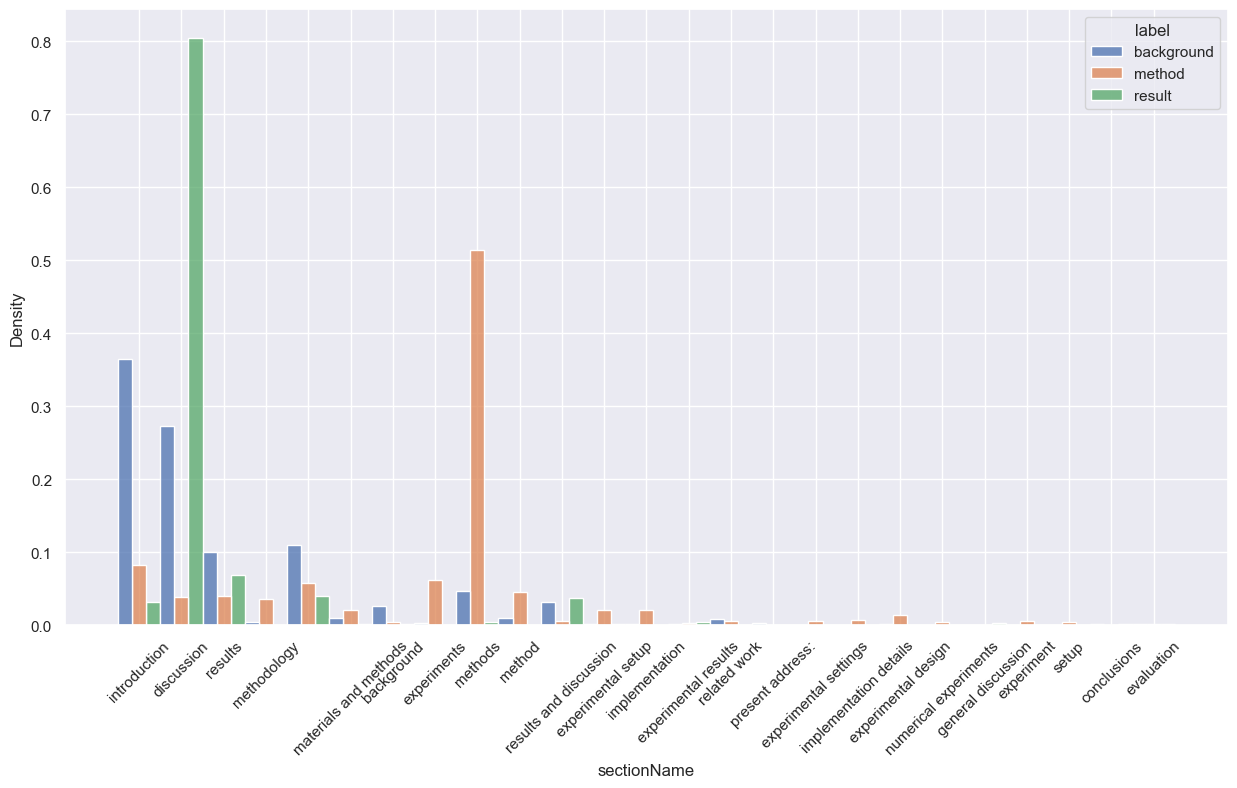

In [75]:
impt_names = set(train_df["sectionName"].value_counts()[:25].keys())
impt_df = train_df[train_df["sectionName"].isin(impt_names)]

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.histplot(data=impt_df, x="sectionName", hue="label", multiple="dodge", stat="density", common_norm=False)
plt.show()

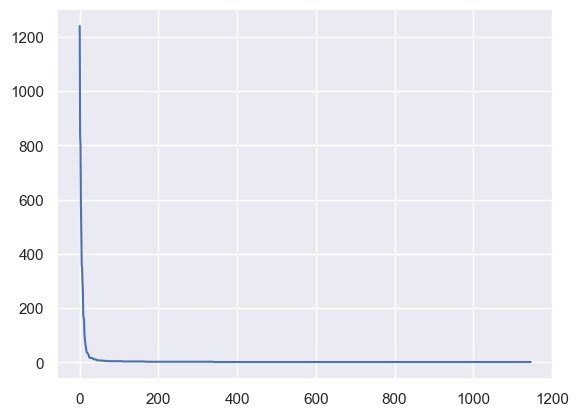

In [4]:
plt.plot(train_df["sectionName"].value_counts().values)